In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Step 1: list files & find likely data files
import os
from pathlib import Path
from google.colab import drive

# mount drive if not already mounted
drive.mount('/content/drive', force_remount=False)

data_dir = Path('/content/drive/MyDrive/ndws_western_dataset')
assert data_dir.exists(), f"Path not found: {data_dir}"

# walk folder, print first 200 files (so output isn't gigantic)
print(f"Listing files under {data_dir} (first 200 files)...\n")
count = 0
for root, dirs, files in os.walk(data_dir):
    for f in files:
        print(os.path.join(root, f))
        count += 1
        if count >= 200:
            break
    if count >= 200:
        break

# collect files by common extensions / patterns
from collections import defaultdict
exts = defaultdict(list)
for root, dirs, files in os.walk(data_dir):
    for f in files:
        p = Path(root) / f
        key = f.lower()
        if '.tfrecord' in key or key.endswith('.tfrecords') or key.endswith('.tfr'):
            ex = '.tfrecord'
        elif key.endswith('.tfindex'):
            ex = '.tfindex'
        elif key.endswith('.tif') or key.endswith('.tiff'):
            ex = '.tif'
        elif key.endswith('.npy'):
            ex = '.npy'
        elif key.endswith('.h5') or key.endswith('.hdf5'):
            ex = '.h5'
        elif key.endswith('.json') or 'dataset' in key or 'info' in key:
            ex = '.json'
        elif key.endswith('.csv'):
            ex = '.csv'
        else:
            ex = Path(f).suffix.lower() or 'other'
        exts[ex].append(str(p))

# print summary
print("\n\nSummary (counts by detected type):")
for k, v in exts.items():
    print(f"{k:8s}: {len(v)} files")

# show up to 10 examples of each important type
for k in ['.tfindex', '.tfrecord', '.tif', '.npy', '.h5', '.json', '.csv']:
    if k in exts:
        print(f"\nExamples for {k}:")
        for p in exts[k][:10]:
            print(" ", p)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Listing files under /content/drive/MyDrive/ndws_western_dataset (first 200 files)...

/content/drive/MyDrive/ndws_western_dataset/cleaned_train_ndws_conus_western_021.tfrecord
/content/drive/MyDrive/ndws_western_dataset/cleaned_train_ndws_conus_western_024.tfrecord
/content/drive/MyDrive/ndws_western_dataset/cleaned_train_ndws_conus_western_023.tfrecord
/content/drive/MyDrive/ndws_western_dataset/cleaned_train_ndws_conus_western_022.tfrecord
/content/drive/MyDrive/ndws_western_dataset/cleaned_eval_ndws_conus_western_000.tfindex
/content/drive/MyDrive/ndws_western_dataset/cleaned_eval_ndws_conus_western_001.tfindex
/content/drive/MyDrive/ndws_western_dataset/cleaned_eval_ndws_conus_western_000.tfrecord
/content/drive/MyDrive/ndws_western_dataset/cleaned_eval_ndws_conus_western_001.tfrecord
/content/drive/MyDrive/ndws_western_dataset/cleaned_eval_ndws_conus_wes

In [3]:
import tensorflow as tf

# Path to one sample TFRecord file
tfrecord_path = "/content/drive/MyDrive/ndws_western_dataset/cleaned_eval_ndws_conus_western_000.tfrecord"

# Create a TFRecordDataset
raw_dataset = tf.data.TFRecordDataset(tfrecord_path)

# Inspect one record
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)


features {
  feature {
    key: "wind_avg"
    value {
      float_list {
        value: 2.54204345
        value: 2.55620861
        value: 2.57735538
        value: 2.60457754
        value: 2.63696933
        value: 2.67362475
        value: 2.71363735
        value: 2.75610137
        value: 2.80011058
        value: 2.84475923
        value: 2.88914108
        value: 2.93235
        value: 2.97348
        value: 3.01162505
        value: 3.04587936
        value: 3.07533646
        value: 3.09909034
        value: 3.11623526
        value: 3.12586498
        value: 3.12707353
        value: 3.11857939
        value: 3.09809446
        value: 3.06656122
        value: 3.02539444
        value: 2.97600842
        value: 2.91981745
        value: 2.85823631
        value: 2.79267955
        value: 2.72456145
        value: 2.6552968
        value: 2.5863
        value: 2.51898503
        value: 2.45476723
        value: 2.39506078
        value: 2.34128
        value: 2.29483938
    

In [4]:
# Extract all feature names from a record
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    feature_dict = example.features.feature

    print("Total features:", len(feature_dict))
    print("\nFeature names and types:")
    for key, value in feature_dict.items():
        # Determine type
        if value.float_list.value:
            dtype = "float"
        elif value.int64_list.value:
            dtype = "int"
        elif value.bytes_list.value:
            dtype = "bytes"
        else:
            dtype = "unknown"
        print(f"{key:30s} -> {dtype}")


Total features: 23

Feature names and types:
gust_med                       -> float
wind_75                        -> float
elevation                      -> float
population                     -> float
chili                          -> float
impervious                     -> float
fuel3                          -> float
viirs_PrevFireMask             -> float
fuel2                          -> float
viirs_FireMask                 -> float
fuel1                          -> float
pdsi                           -> float
water                          -> float
tmp_day                        -> float
erc                            -> float
NDVI                           -> float
pr                             -> float
wdir_wind                      -> float
wdir_gust                      -> float
bi                             -> float
tmp_75                         -> float
avg_sph                        -> float
wind_avg                       -> float


Raw length of wind_avg: 4096


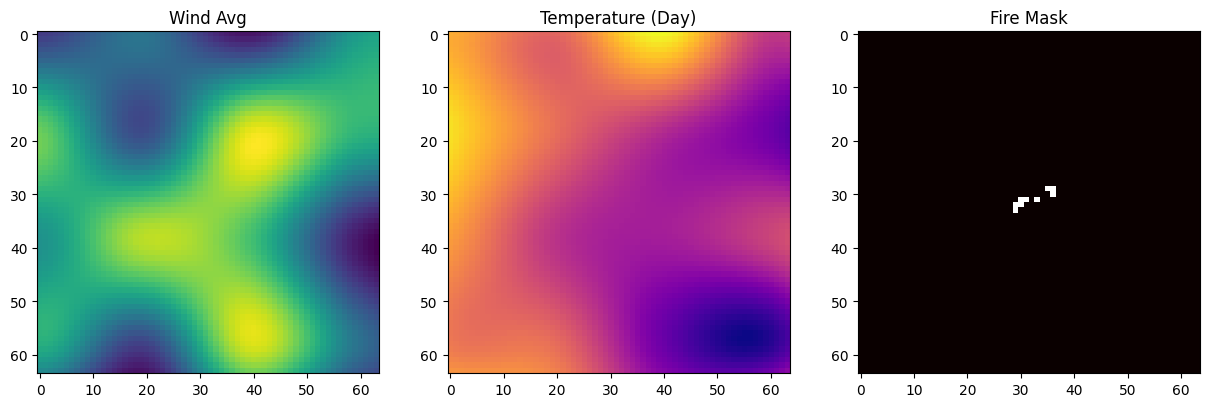

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load one record and extract features
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    feature_dict = example.features.feature

    # Convert one feature (e.g., wind_avg) to numpy
    wind_avg = np.array(feature_dict["wind_avg"].float_list.value)
    tmp_day = np.array(feature_dict["tmp_day"].float_list.value)
    fire_mask = np.array(feature_dict["viirs_FireMask"].float_list.value)
    break

# Check shape (we’ll reshape next)
print("Raw length of wind_avg:", len(wind_avg))

# Try reshaping into 2D grid (most wildfire data is 32x32 or 64x64)
grid_size = int(np.sqrt(len(wind_avg)))
wind_grid = wind_avg.reshape((grid_size, grid_size))
tmp_grid = tmp_day.reshape((grid_size, grid_size))
fire_grid = fire_mask.reshape((grid_size, grid_size))

# Plot heatmaps
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(wind_grid, cmap='viridis'); axes[0].set_title('Wind Avg')
axes[1].imshow(tmp_grid, cmap='plasma'); axes[1].set_title('Temperature (Day)')
axes[2].imshow(fire_grid, cmap='hot'); axes[2].set_title('Fire Mask')
plt.show()


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

# Directory
tfrecord_dir = "/content/drive/MyDrive/ndws_western_dataset"

# Load one TFRecord for inspection
tfrecord_file = os.path.join(tfrecord_dir, "cleaned_eval_ndws_conus_western_000.tfrecord")

raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

stats = {}

for raw_record in raw_dataset.take(1):  # just one sample
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    feature_dict = example.features.feature

    for key, value in feature_dict.items():
        vals = np.array(value.float_list.value)
        stats[key] = {
            "mean": np.mean(vals),
            "std": np.std(vals),
            "min": np.min(vals),
            "max": np.max(vals)
        }

df_stats = pd.DataFrame(stats).T
print(df_stats.round(4))


                         mean        std        min        max
gust_med               6.4371     1.0013     4.3958     9.1296
wind_75                4.5351     0.9423     2.4375     6.4309
elevation           1518.7988   276.5665   804.0000  2344.0000
population             0.0099     0.0189     0.0000     0.1899
chili                180.8064    47.5647     0.0000   254.0000
impervious             0.1399     0.4552     0.0000     7.0000
fuel3                 -0.1834     1.3308    -3.9051     3.2983
viirs_PrevFireMask     0.0051     0.0714     0.0000     1.0000
fuel2                  0.5426     0.7506    -1.7386     4.2761
viirs_FireMask         0.0022     0.0468     0.0000     1.0000
fuel1                  0.0282     0.5207    -1.2486     2.0892
pdsi                  -1.0271     0.5784    -1.6212     0.8493
water                  0.1589     2.3456     0.0000    76.0000
tmp_day               24.8555     1.6998    20.8292    29.0572
erc                   55.7233     3.0838    47.0283    

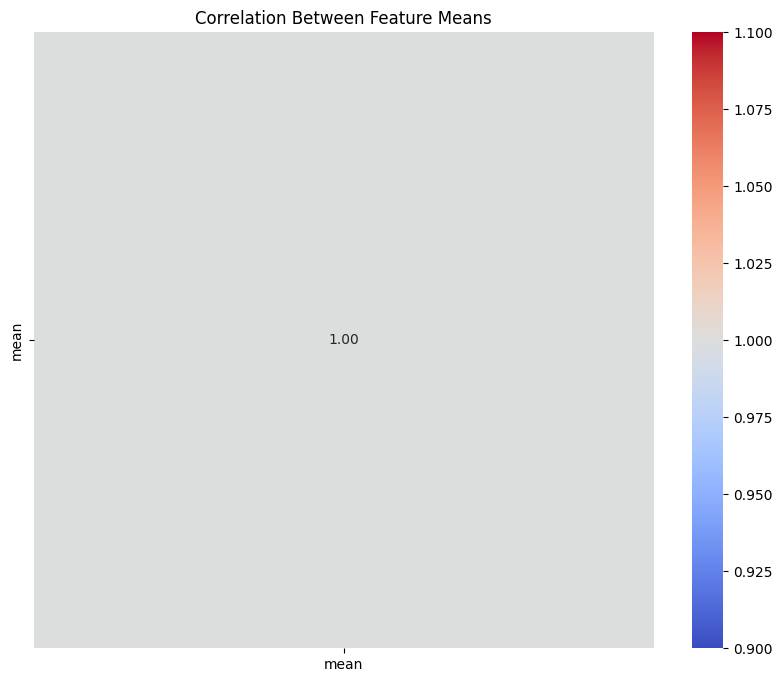

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_stats[['mean']].T.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_stats[['mean']].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Feature Means")
plt.show()


In [11]:
# Extract example
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    feature_dict = {k: np.array(v.float_list.value) for k, v in example.features.feature.items()}

fire_mask = feature_dict["viirs_FireMask"].reshape(64, 64)
fire_mask_bin = (fire_mask > 0).astype(int)

compare = {}
for key, arr in feature_dict.items():
    arr2d = arr.reshape(64, 64)
    fire_vals = arr2d[fire_mask_bin == 1]
    nofire_vals = arr2d[fire_mask_bin == 0]

    compare[key] = {
        "fire_mean": np.mean(fire_vals) if len(fire_vals) > 0 else np.nan,
        "nofire_mean": np.mean(nofire_vals)
    }

df_compare = pd.DataFrame(compare).T
print(df_compare.round(3))


                    fire_mean  nofire_mean
gust_med                7.730        6.434
wind_75                 5.683        4.533
elevation            1644.444     1518.522
population              0.008        0.010
chili                 204.444      180.754
impervious              0.000        0.140
fuel3                   0.142       -0.184
viirs_PrevFireMask      0.778        0.003
fuel2                   0.553        0.543
viirs_FireMask          1.000        0.000
fuel1                  -0.254        0.029
pdsi                   -1.541       -1.026
water                   0.000        0.159
tmp_day                23.961       24.857
erc                    56.633       55.721
NDVI                 5751.778     6518.140
pr                      0.000        0.000
wdir_wind              -2.314       -2.126
wdir_gust              -2.300       -2.097
bi                     42.545       42.357
tmp_75                 24.247       25.068
avg_sph                 0.006        0.007
wind_avg   

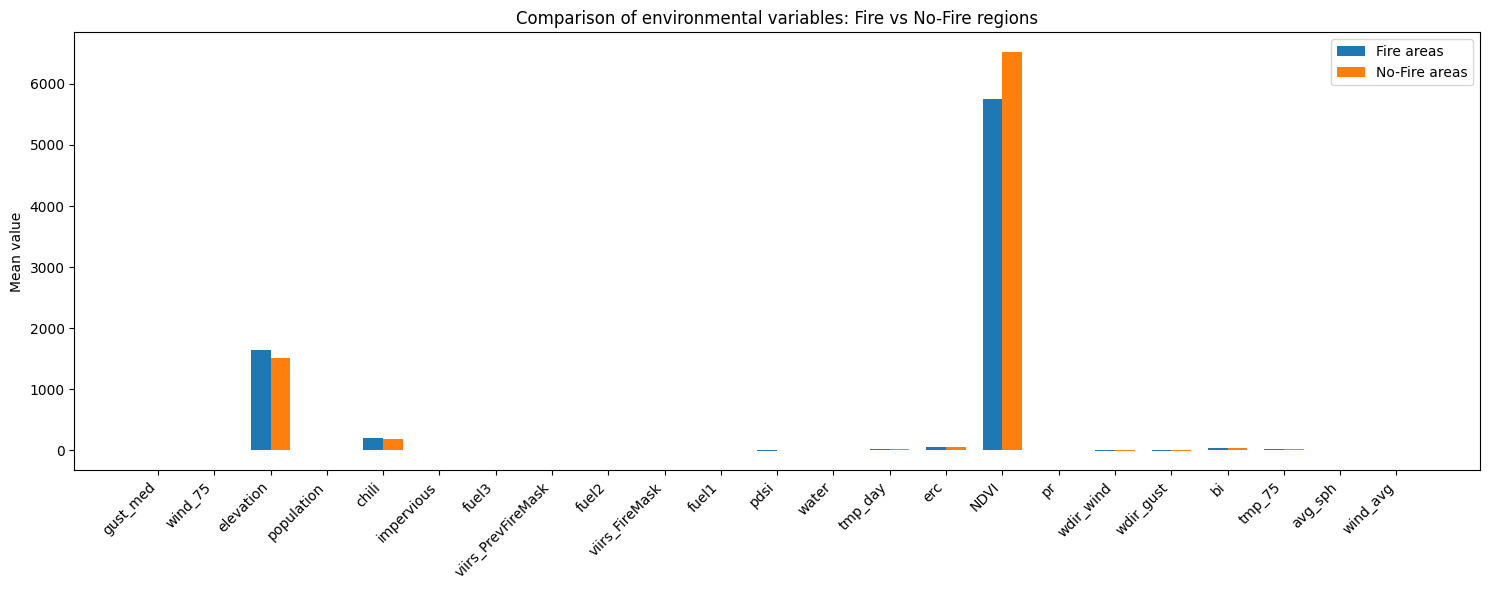

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Plot fire vs no-fire means
features = df_compare.index
fire_means = df_compare["fire_mean"]
nofire_means = df_compare["nofire_mean"]

x = np.arange(len(features))  # feature positions
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(15,6))
ax.bar(x - width/2, fire_means, width, label='Fire areas')
ax.bar(x + width/2, nofire_means, width, label='No-Fire areas')

ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha='right')
ax.set_ylabel('Mean value')
ax.set_title('Comparison of environmental variables: Fire vs No-Fire regions')
ax.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


                    correlation
viirs_FireMask            1.000
viirs_PrevFireMask        0.508
gust_med                  0.061
wind_75                   0.057
wind_avg                  0.057
chili                     0.023
elevation                 0.021
erc                       0.014
fuel3                     0.011
bi                        0.004
fuel2                     0.001
water                    -0.003
population               -0.004
wdir_wind                -0.011
wdir_gust                -0.012
impervious               -0.014
tmp_75                   -0.023
tmp_day                  -0.025
fuel1                    -0.025
NDVI                     -0.033
pdsi                     -0.042
avg_sph                  -0.045
pr                          NaN


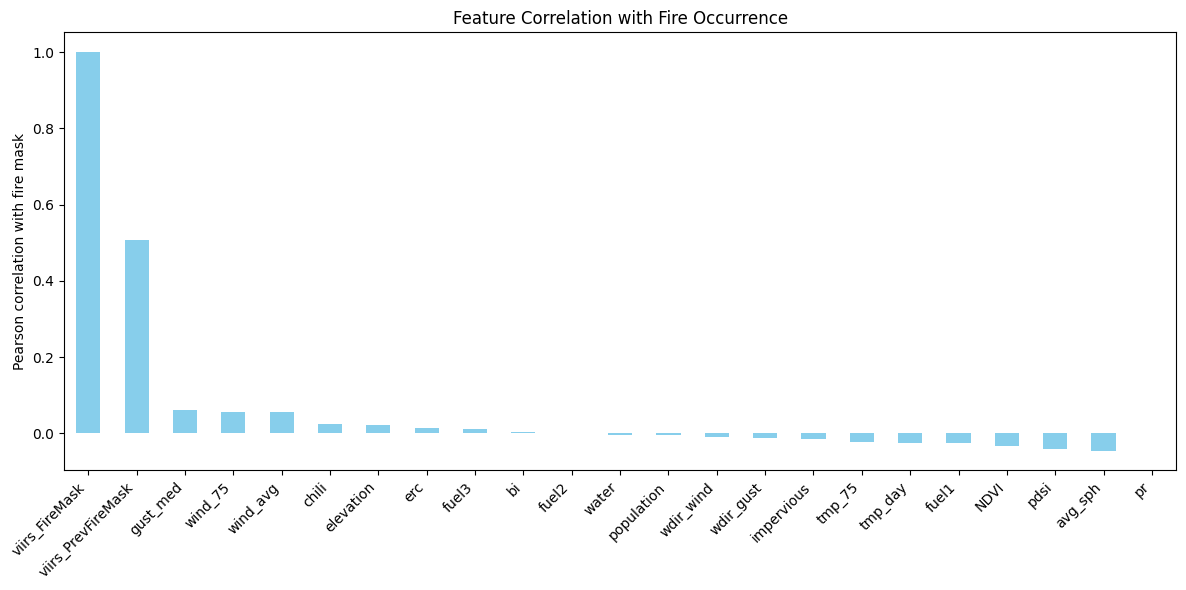

In [14]:
# Flatten arrays for correlation
fire_mask_flat = fire_mask_bin.flatten()

correlations = {}
for key, arr in feature_dict.items():
    feature_flat = arr.flatten()
    corr = np.corrcoef(feature_flat, fire_mask_flat)[0,1]  # Pearson correlation
    correlations[key] = corr

# Convert to DataFrame for easy visualization
df_corr = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])
df_corr = df_corr.sort_values(by='correlation', ascending=False)
print(df_corr.round(3))

# Plot correlations
plt.figure(figsize=(12,6))
df_corr['correlation'].plot(kind='bar', color='skyblue')
plt.ylabel('Pearson correlation with fire mask')
plt.title('Feature Correlation with Fire Occurrence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [16]:
import math
import numpy as np
import tensorflow as tf
import pandas as pd
import os

tfrecord_dir = "/content/drive/MyDrive/ndws_western_dataset"
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(tfrecord_dir) if f.endswith(".tfrecord")]

feature_sums = {}
feature_sqsums = {}
corr_sums = {}
corr_counts = {}
total_count = 0
max_records = 800   # limit to speed up

record_counter = 0
for file in tfrecord_files:
    dataset = tf.data.TFRecordDataset(file)
    for raw_record in dataset.take(max_records):
        record_counter += 1
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        feat = {k: np.array(v.float_list.value) for k, v in example.features.feature.items()}

        grid = int(math.sqrt(len(feat["viirs_FireMask"])))
        mask = (feat["viirs_FireMask"].reshape(grid, grid) > 0).astype(int).flatten()

        for k, arr in feat.items():
            arr_flat = arr.flatten()

            # skip all-NaN or constant arrays
            if np.all(arr_flat == arr_flat[0]):
                continue

            if k not in feature_sums:
                feature_sums[k] = 0
                feature_sqsums[k] = 0
                corr_sums[k] = 0
                corr_counts[k] = 0

            feature_sums[k] += arr_flat.sum()
            feature_sqsums[k] += (arr_flat**2).sum()
            total_count += len(arr_flat)

            # correlation (ignore NaN)
            try:
                corr = np.corrcoef(arr_flat, mask)[0, 1]
                if not np.isnan(corr):
                    corr_sums[k] += corr
                    corr_counts[k] += 1
            except Exception:
                pass

    if record_counter >= max_records:
        break

# summarize
summary = {}
for k in feature_sums.keys():
    mean = feature_sums[k] / total_count
    std = np.sqrt(feature_sqsums[k]/total_count - mean**2)
    corr_mean = corr_sums[k]/corr_counts[k] if corr_counts[k] else np.nan
    summary[k] = {'mean': mean, 'std': std, 'corr_mean': corr_mean}

df_summary = pd.DataFrame(summary).T.sort_values('corr_mean', ascending=False)
print(df_summary.round(3))


                       mean       std  corr_mean
viirs_FireMask        0.002     0.040      1.000
viirs_PrevFireMask    0.002     0.043      0.376
elevation            51.373   270.962      0.053
gust_med              0.216     1.118      0.053
wind_avg              0.109     0.562      0.024
fuel2                 0.015     0.215      0.024
wind_75               0.142     0.728      0.021
erc                   3.057    14.863      0.013
fuel3                -0.019     0.348      0.004
pr                    0.009     0.284      0.003
wdir_gust             0.016     0.397      0.003
wdir_wind             0.016     0.394      0.003
fuel1                 0.004     0.138      0.001
chili                 8.014    38.287     -0.001
impervious            0.032     0.879     -0.006
water                 0.121     3.090     -0.013
pdsi                 -0.100     0.619     -0.017
population            0.549    29.386     -0.021
bi                    2.298    11.311     -0.021
NDVI                

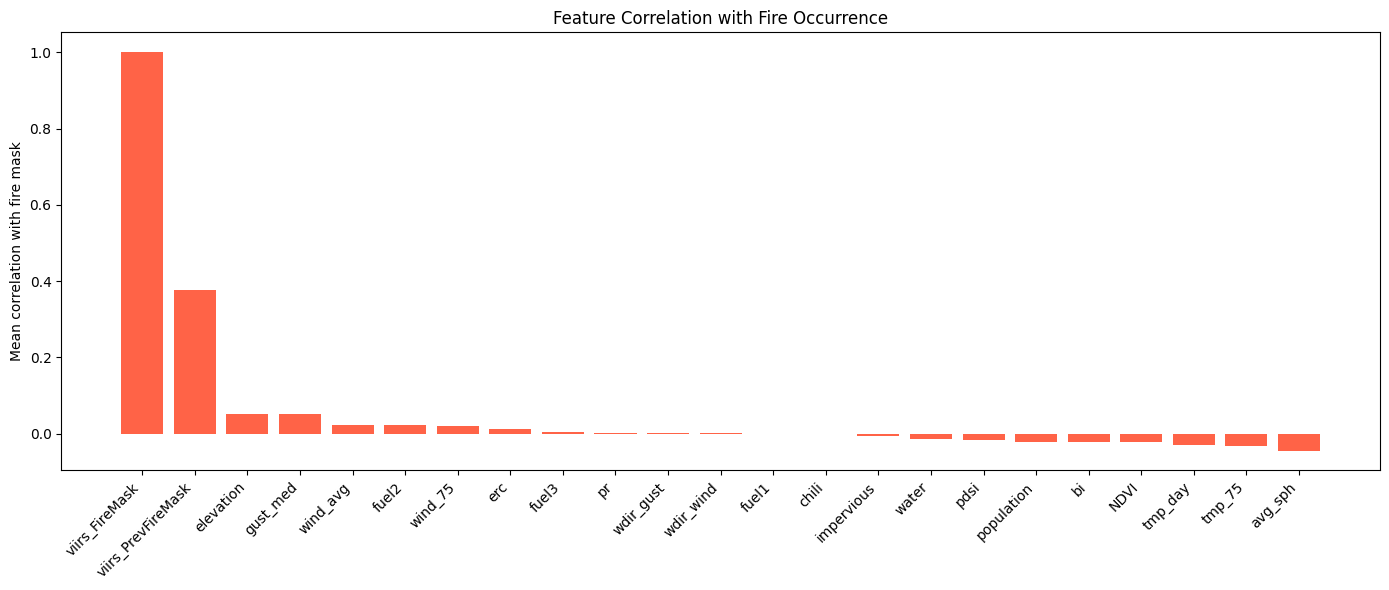

In [17]:
import matplotlib.pyplot as plt

df_corr_sorted = df_summary.sort_values(by='corr_mean', ascending=False)

plt.figure(figsize=(14,6))
plt.bar(df_corr_sorted.index, df_corr_sorted['corr_mean'], color='tomato')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean correlation with fire mask')
plt.title('Feature Correlation with Fire Occurrence')
plt.tight_layout()
plt.show()


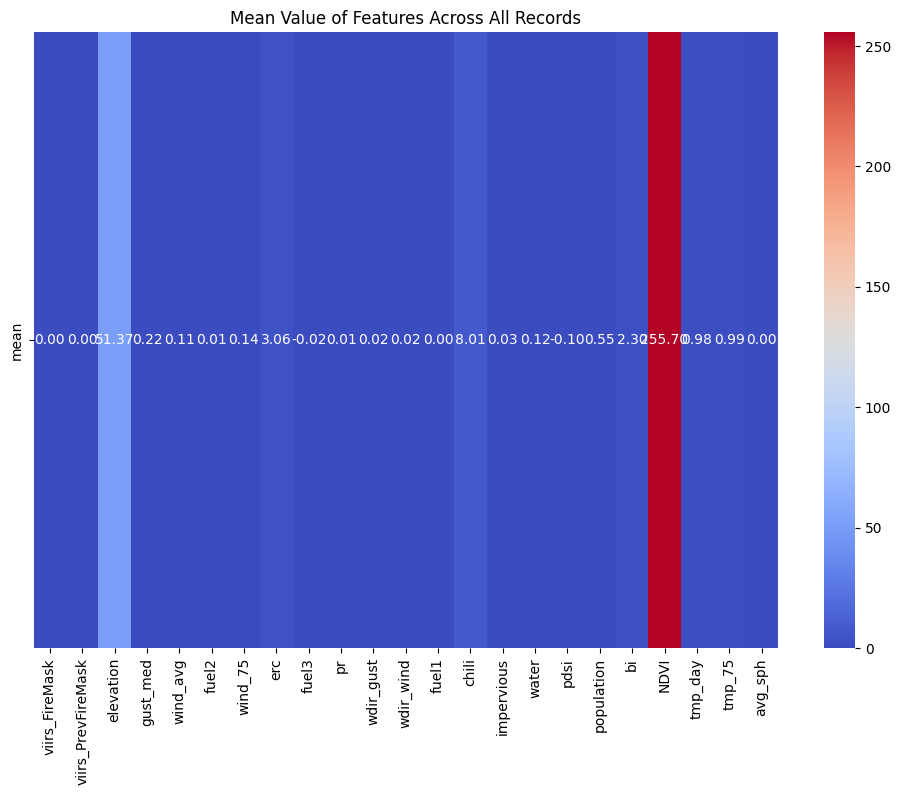

In [18]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(df_summary[['mean']].T, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mean Value of Features Across All Records')
plt.show()


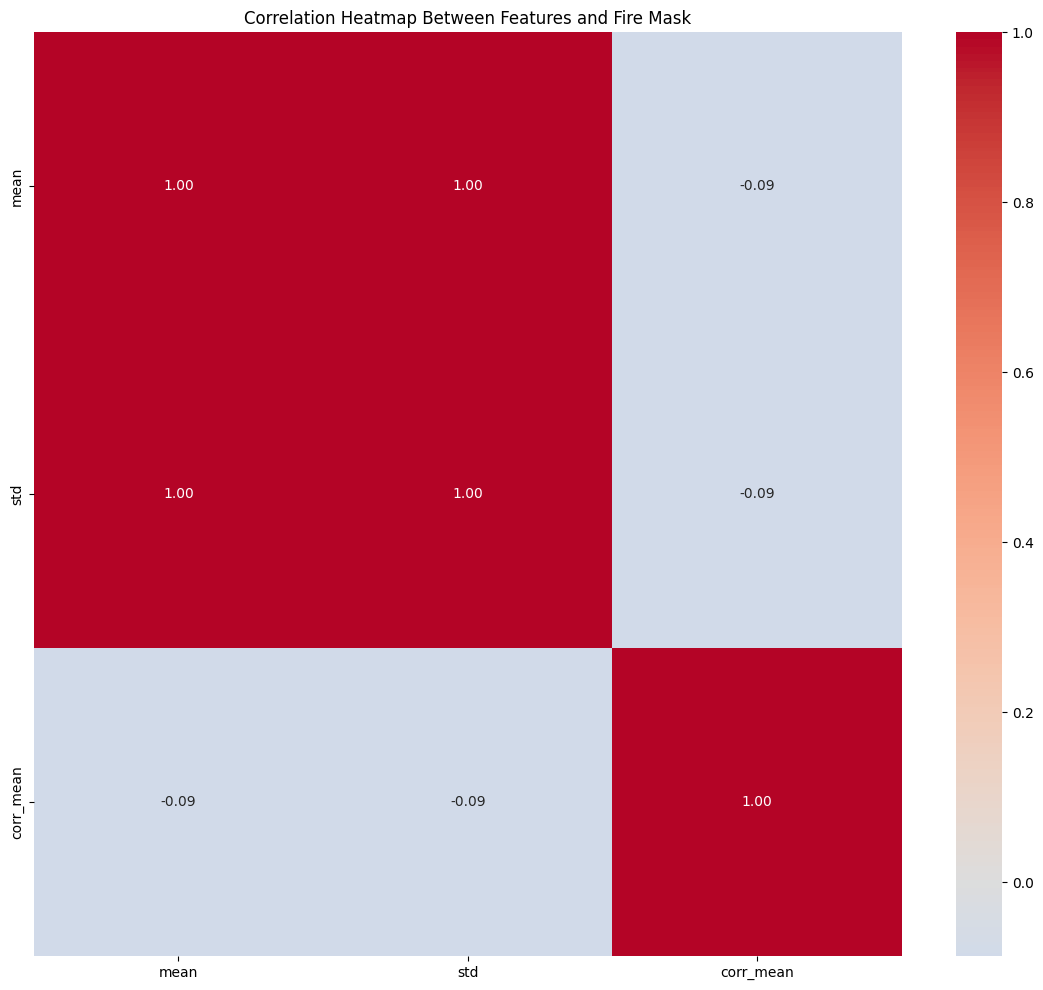

In [19]:
plt.figure(figsize=(14,12))
sns.heatmap(df_summary.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap Between Features and Fire Mask')
plt.show()


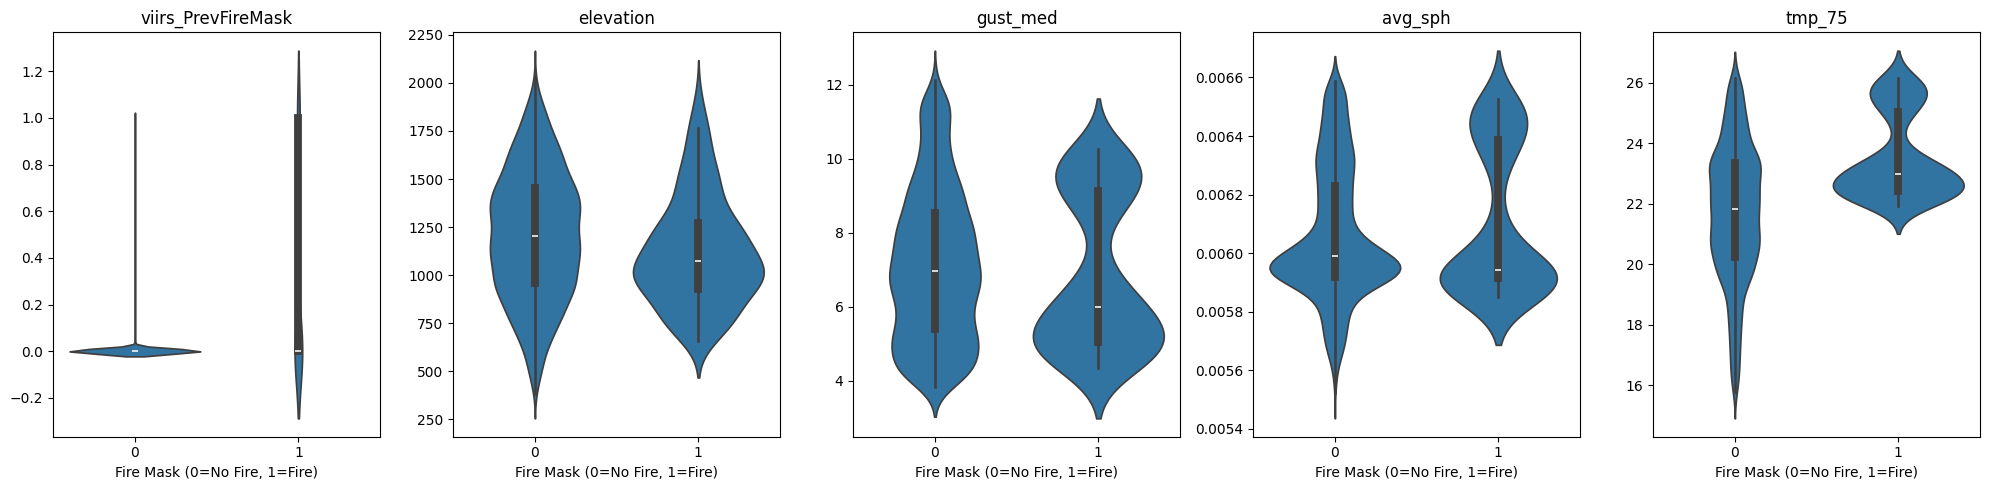

In [20]:
top_features = df_summary['corr_mean'].abs().sort_values(ascending=False).index[1:6]  # skip FireMask itself

fig, axes = plt.subplots(1, len(top_features), figsize=(20,5))
for i, feat in enumerate(top_features):
    sns.violinplot(x=fire_mask_bin.flatten(), y=feature_dict[feat].flatten(), ax=axes[i])
    axes[i].set_title(feat)
    axes[i].set_xlabel('Fire Mask (0=No Fire, 1=Fire)')

plt.tight_layout()
plt.show()


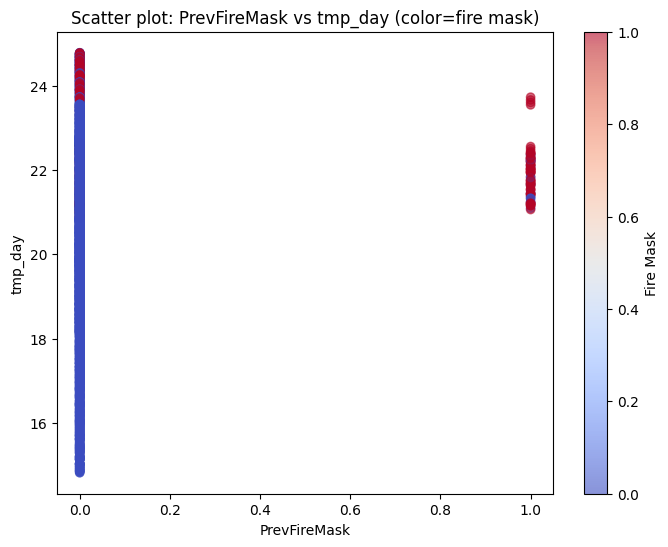

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(feature_dict['viirs_PrevFireMask'].flatten(), feature_dict['tmp_day'].flatten(),
            c=fire_mask_bin.flatten(), cmap='coolwarm', alpha=0.6)
plt.xlabel('PrevFireMask')
plt.ylabel('tmp_day')
plt.title('Scatter plot: PrevFireMask vs tmp_day (color=fire mask)')
plt.colorbar(label='Fire Mask')
plt.show()


/tmp/ipython-input-404217874.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_corr_sorted.index, rotation=45, ha='right')


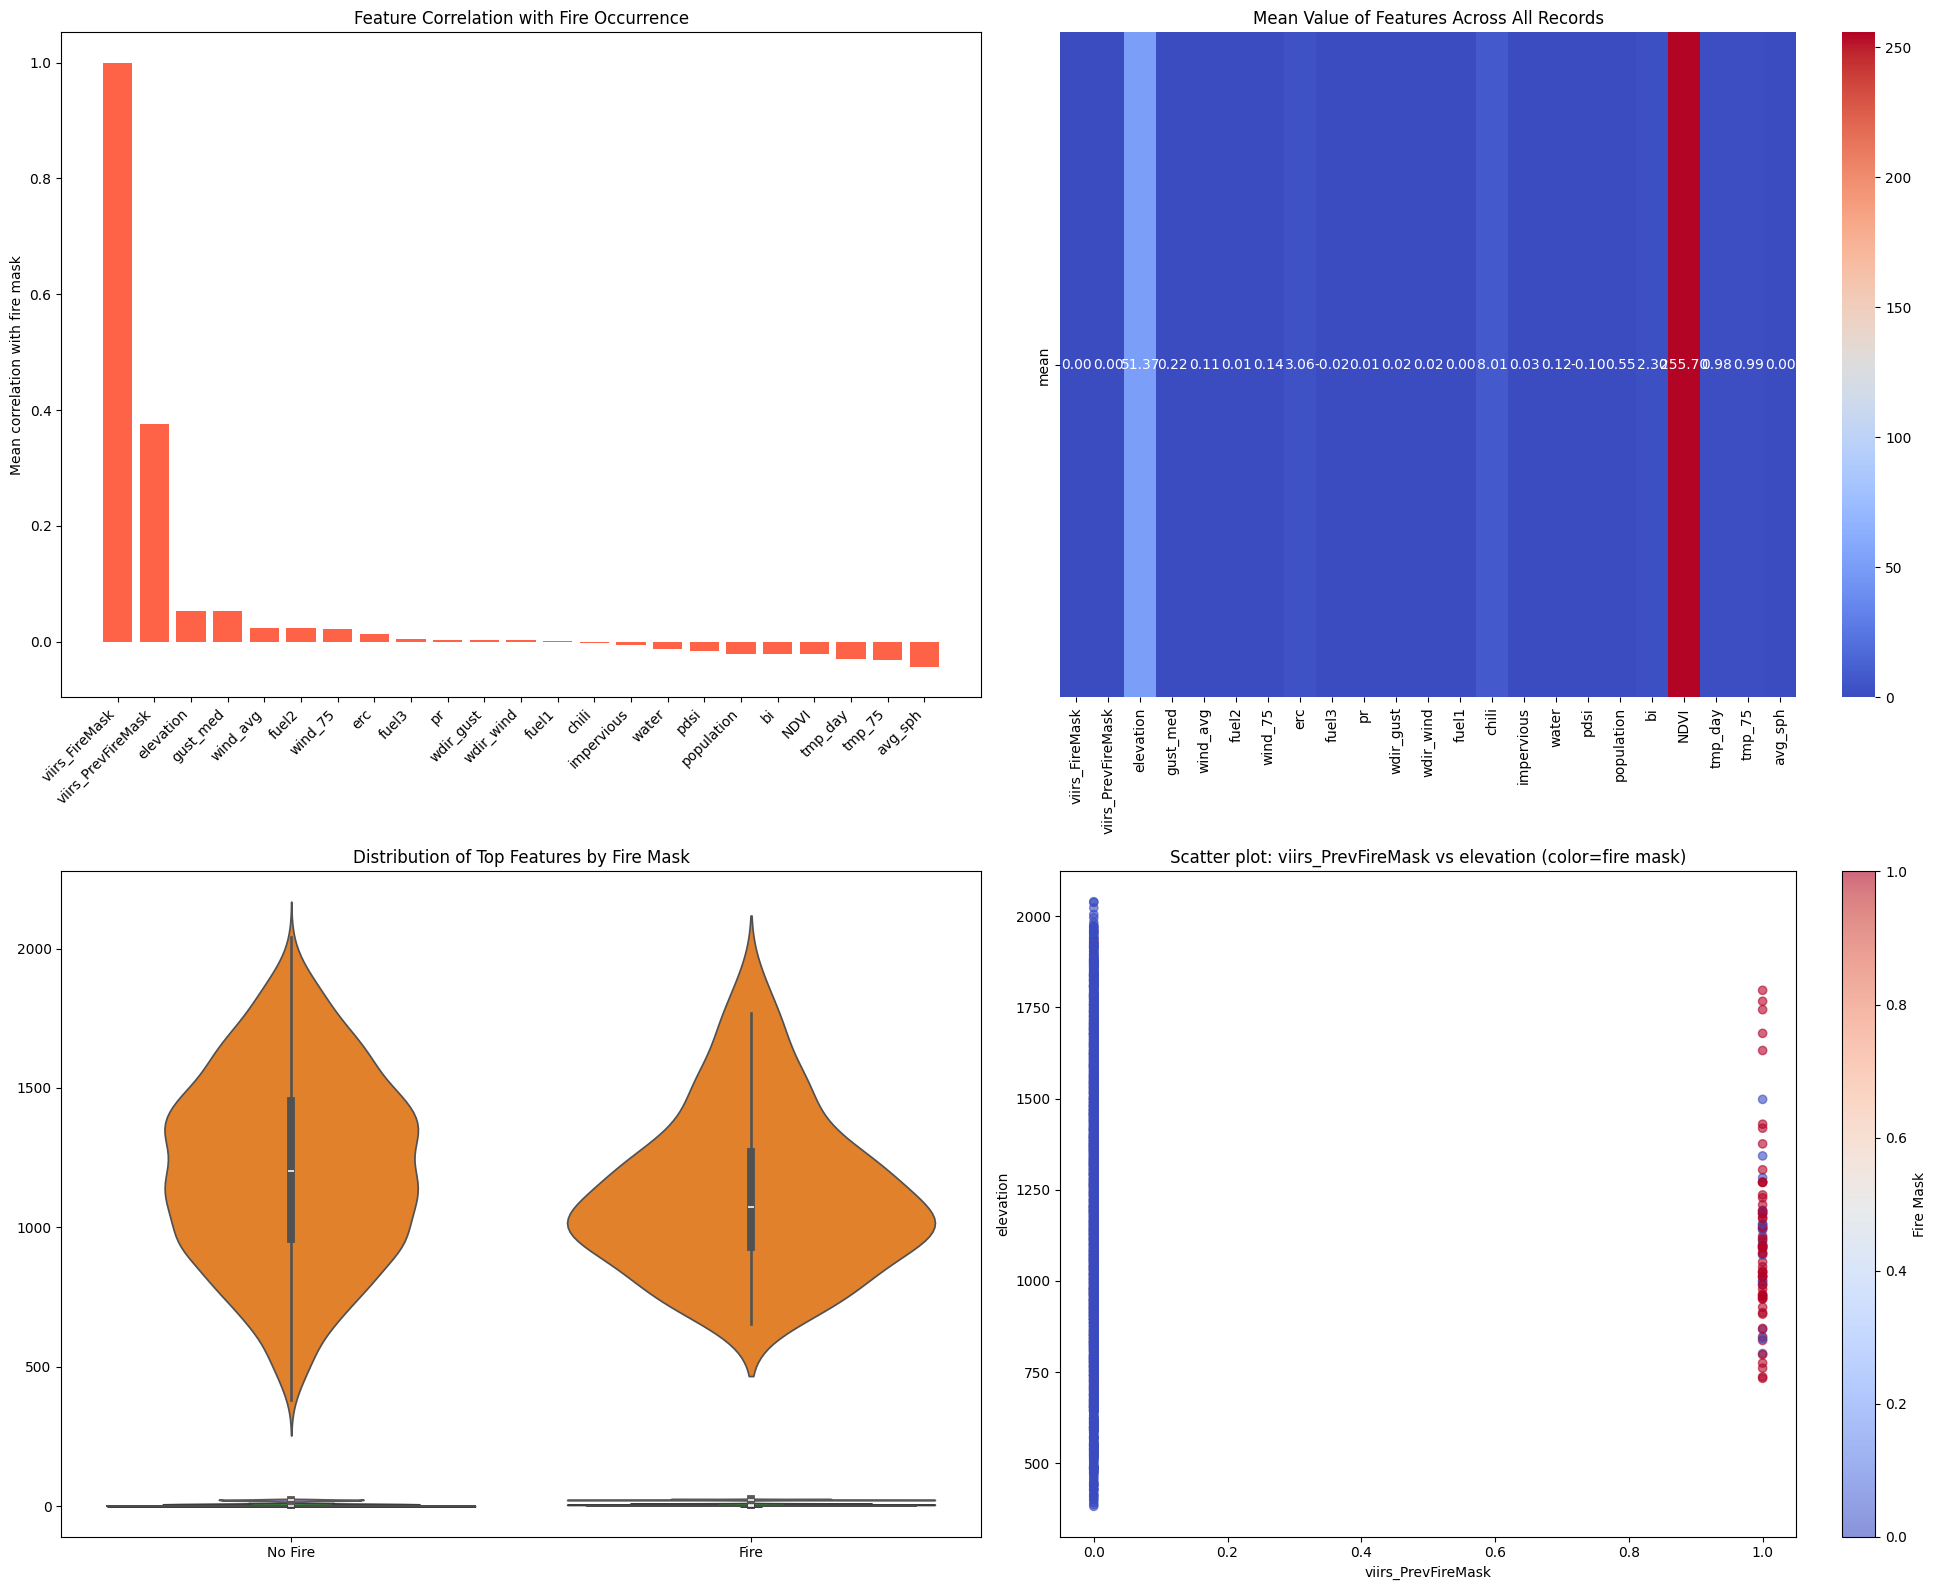

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Choose top features for violin plots
top_features = df_summary['corr_mean'].abs().sort_values(ascending=False).index[1:6]  # skip FireMask itself

# Prepare figure
fig, axes = plt.subplots(2, 2, figsize=(20,16))
ax1, ax2, ax3, ax4 = axes.ravel()

# --- 1. Bar chart: correlation with fire ---
df_corr_sorted = df_summary.sort_values(by='corr_mean', ascending=False)
ax1.bar(df_corr_sorted.index, df_corr_sorted['corr_mean'], color='tomato')
ax1.set_xticklabels(df_corr_sorted.index, rotation=45, ha='right')
ax1.set_ylabel('Mean correlation with fire mask')
ax1.set_title('Feature Correlation with Fire Occurrence')

# --- 2. Heatmap: feature means ---
sns.heatmap(df_summary[['mean']].T, annot=True, fmt=".2f", cmap='coolwarm', ax=ax2)
ax2.set_title('Mean Value of Features Across All Records')

# --- 3. Violin plots: top features vs fire mask ---
for i, feat in enumerate(top_features):
    sns.violinplot(x=fire_mask_bin.flatten(), y=feature_dict[feat].flatten(), ax=ax3)
ax3.set_xticks([0,1])
ax3.set_xticklabels(['No Fire','Fire'])
ax3.set_title('Distribution of Top Features by Fire Mask')

# --- 4. Scatter plot: two top correlated features ---
feat_x = top_features[0]
feat_y = top_features[1]
scatter = ax4.scatter(feature_dict[feat_x].flatten(), feature_dict[feat_y].flatten(),
                      c=fire_mask_bin.flatten(), cmap='coolwarm', alpha=0.6)
ax4.set_xlabel(feat_x)
ax4.set_ylabel(feat_y)
ax4.set_title(f'Scatter plot: {feat_x} vs {feat_y} (color=fire mask)')
plt.colorbar(scatter, ax=ax4, label='Fire Mask')

plt.tight_layout()
plt.show()


In [25]:
IMG_SIZE = 64


In [26]:
def parse_tfrecord(raw_record):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    feat = {k: np.array(v.float_list.value, dtype=np.float32) for k,v in example.features.feature.items()}

    # Prepare input features
    X_features = []
    for k in feat.keys():
        if k != 'viirs_FireMask':
            arr = feat[k].reshape(IMG_SIZE, IMG_SIZE)
            X_features.append(arr)
    X = np.stack(X_features, axis=-1)  # (IMG_SIZE, IMG_SIZE, num_features)

    # Target
    y = feat['viirs_FireMask'].reshape(IMG_SIZE, IMG_SIZE)
    y = (y > 0).astype(np.float32)  # binary mask

    return X, y


In [27]:
raw_dataset = tf.data.TFRecordDataset(tfrecord_files[0])
X_list, y_list = [], []

for raw_record in raw_dataset.take(1000):  # take first 1000 records for demo
    X, y = parse_tfrecord(raw_record)
    X_list.append(X)
    y_list.append(y)

X_array = np.array(X_list)
y_array = np.array(y_list)

print("X shape:", X_array.shape)  # (num_samples, 64, 64, num_features)
print("y shape:", y_array.shape)  # (num_samples, 64, 64)


X shape: (443, 64, 64, 22)
y shape: (443, 64, 64)


In [28]:
from tensorflow.keras import layers, models

def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.UpSampling2D((2,2))(c3)
    u4 = layers.Concatenate()([u4, c2])
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D((2,2))(c4)
    u5 = layers.Concatenate()([u5, c1])
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)  # binary mask output

    model = models.Model(inputs, outputs)
    return model

# Build the model
unet_model = build_unet((64, 64, 22))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      6,368 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_8[0][0]  

 Total params: 477,025 (1.82 MB)

 Trainable params: 477,025 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
from sklearn.model_selection import train_test_split

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

history = unet_model.fit(
    X_train, y_train[..., np.newaxis],   # add channel dimension
    validation_data=(X_val, y_val[..., np.newaxis]),
    batch_size=16,
    epochs=10
)


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8191 - loss: 25.7600 - val_accuracy: 0.9651 - val_loss: 1.9035
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9280 - loss: 1.0361 - val_accuracy: 0.9211 - val_loss: 0.4293
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9242 - loss: 0.4094 - val_accuracy: 0.9402 - val_loss: 0.2601
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9429 - loss: 0.2770 - val_accuracy: 0.9584 - val_loss: 0.2060
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9478 - loss: 0.2379 - val_accuracy: 0.9607 - val_loss: 0.1799
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9555 - loss: 0.1951 - val_accuracy: 0.9645 - val_loss: 0.1601
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9576 - loss: 0.1830 - val_accuracy: 0.9641 - val_loss: 0.1540
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9590 - loss: 0.1675 - val_accuracy: 0.9657 - val_loss

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 655ms/step


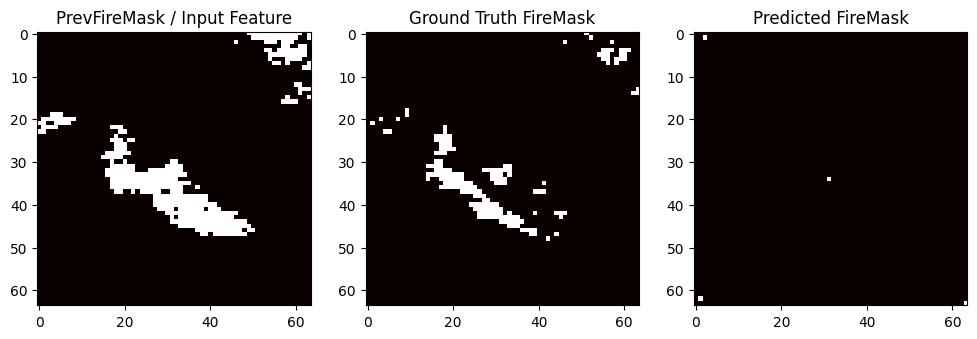

In [30]:
# Predict FireMask on validation set
y_pred = unet_model.predict(X_val)
y_pred_bin = (y_pred > 0.5).astype(int)  # threshold for binary mask

# Visualize one sample
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("PrevFireMask / Input Feature")
plt.imshow(X_val[0,:,:,7], cmap='hot')  # example feature: PrevFireMask index may vary

plt.subplot(1,3,2)
plt.title("Ground Truth FireMask")
plt.imshow(y_val[0], cmap='hot')

plt.subplot(1,3,3)
plt.title("Predicted FireMask")
plt.imshow(y_pred_bin[0,:,:,0], cmap='hot')
plt.show()


In [31]:
import numpy as np

def iou_score(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union == 0:
        return 1.0  # both empty → perfect score
    return intersection / union

def dice_score(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()
    if total == 0:
        return 1.0
    return 2 * intersection / total

# Evaluate on validation set
ious = []
dices = []
for i in range(len(y_val)):
    ious.append(iou_score(y_val[i], y_pred_bin[i,:,:,0]))
    dices.append(dice_score(y_val[i], y_pred_bin[i,:,:,0]))

print("Mean IoU:", np.mean(ious))
print("Mean Dice / F1-score:", np.mean(dices))


Mean IoU: 0.0035058217718282585
Mean Dice / F1-score: 0.0068266624554723255


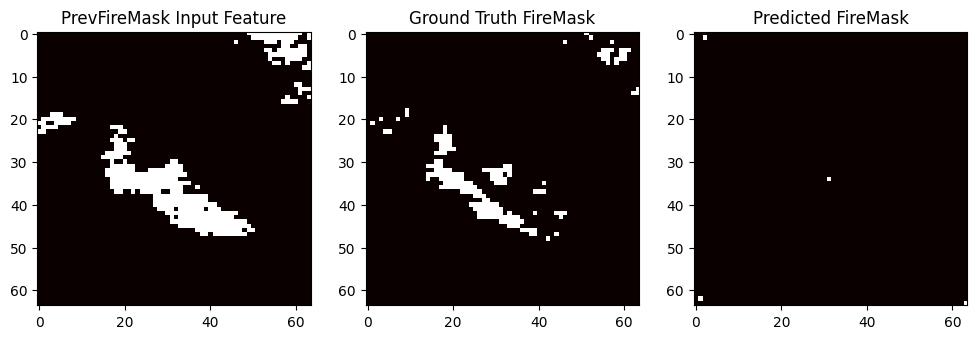

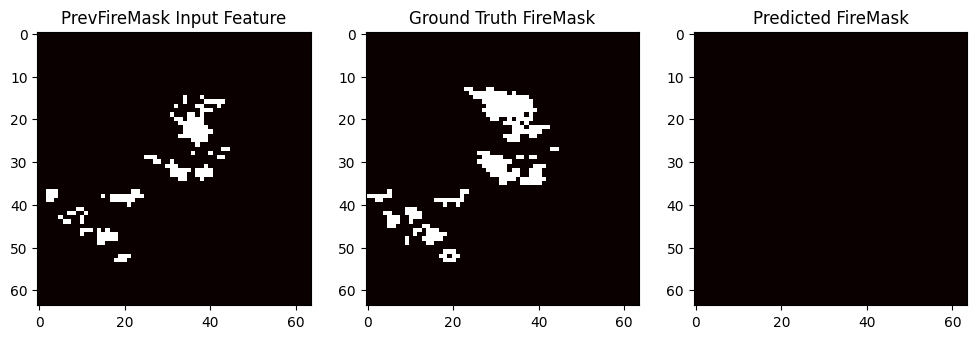

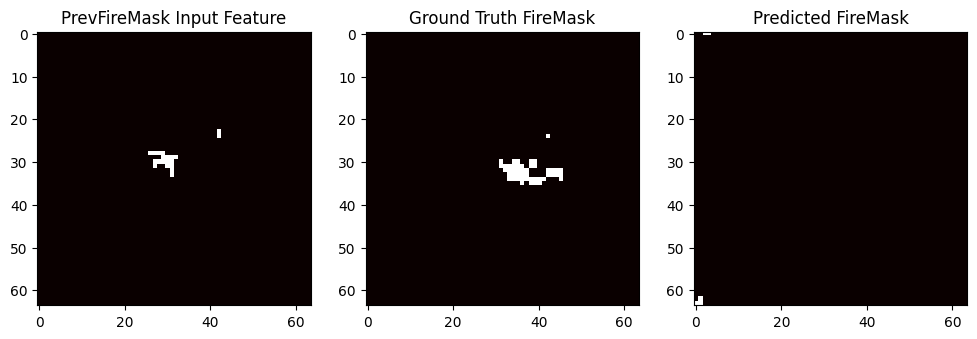

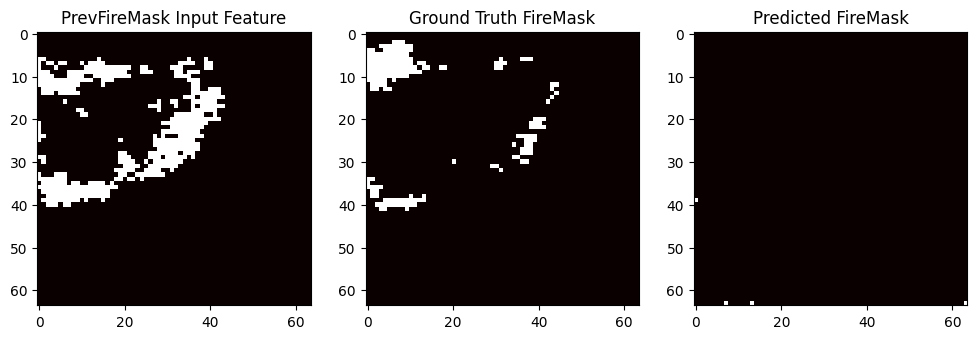

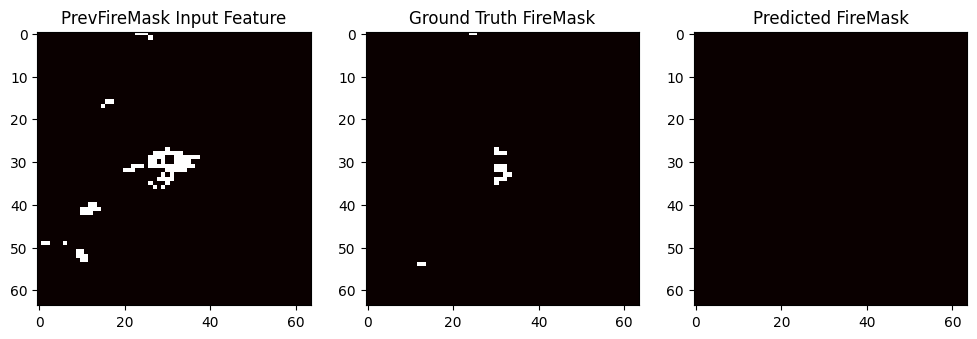

In [32]:
import matplotlib.pyplot as plt

num_samples = 5
for i in range(num_samples):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("PrevFireMask Input Feature")
    plt.imshow(X_val[i,:,:,7], cmap='hot')  # example feature
    plt.subplot(1,3,2)
    plt.title("Ground Truth FireMask")
    plt.imshow(y_val[i], cmap='hot')
    plt.subplot(1,3,3)
    plt.title("Predicted FireMask")
    plt.imshow(y_pred_bin[i,:,:,0], cmap='hot')
    plt.show()


FireMask              1.000000
viirs_PrevFireMask    0.467642
erc                   0.115932
bi                    0.110660
gust_med              0.109838
elevation             0.098318
tmp_day               0.074122
tmp_75                0.073440
wind_avg              0.065289
wind_75               0.063377
avg_sph               0.055062
fuel2                 0.041167
chili                 0.016632
fuel1                 0.008385
wdir_gust             0.002311
wdir_wind            -0.000433
fuel3                -0.001278
impervious           -0.006999
population           -0.015753
water                -0.024138
pr                   -0.031165
NDVI                 -0.049027
pdsi                 -0.122396
Name: FireMask, dtype: float64


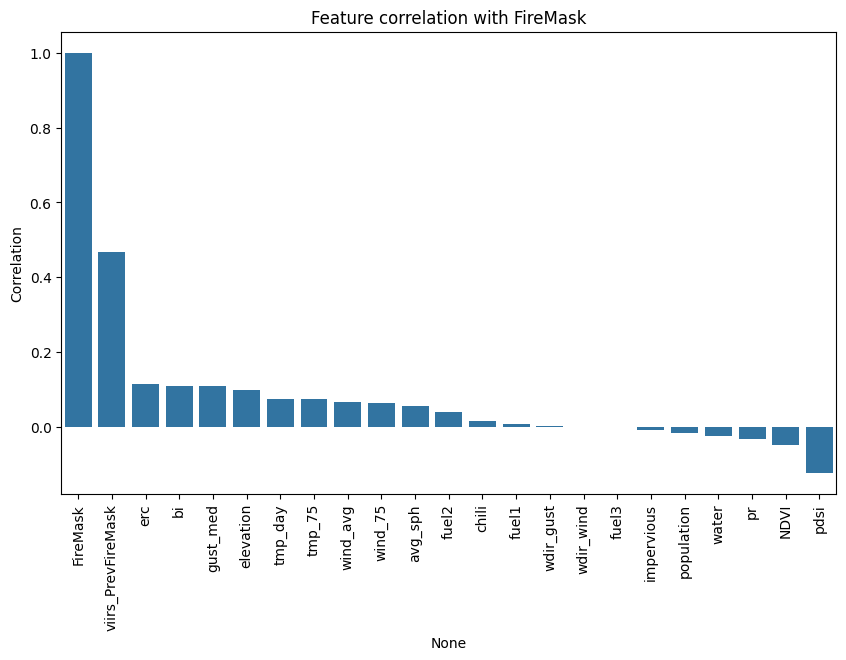

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten all arrays for correlation analysis
X_flat = X_array.reshape(-1, X_array.shape[-1])
y_flat = y_array.flatten()

feature_names = [
    'gust_med','wind_75','elevation','population','chili','impervious','fuel3',
    'viirs_PrevFireMask','fuel2','fuel1','pdsi','water','tmp_day','erc',
    'NDVI','pr','wdir_wind','wdir_gust','bi','tmp_75','avg_sph','wind_avg'
]  # 22 features only


import pandas as pd
df = pd.DataFrame(X_flat, columns=feature_names)
df['FireMask'] = y_flat

# Compute correlations
corr = df.corr()['FireMask'].sort_values(ascending=False)
print(corr)

# Plot heatmap of correlations
plt.figure(figsize=(10,6))
sns.barplot(x=corr.index, y=corr.values)
plt.xticks(rotation=90)
plt.title("Feature correlation with FireMask")
plt.ylabel("Correlation")
plt.show()


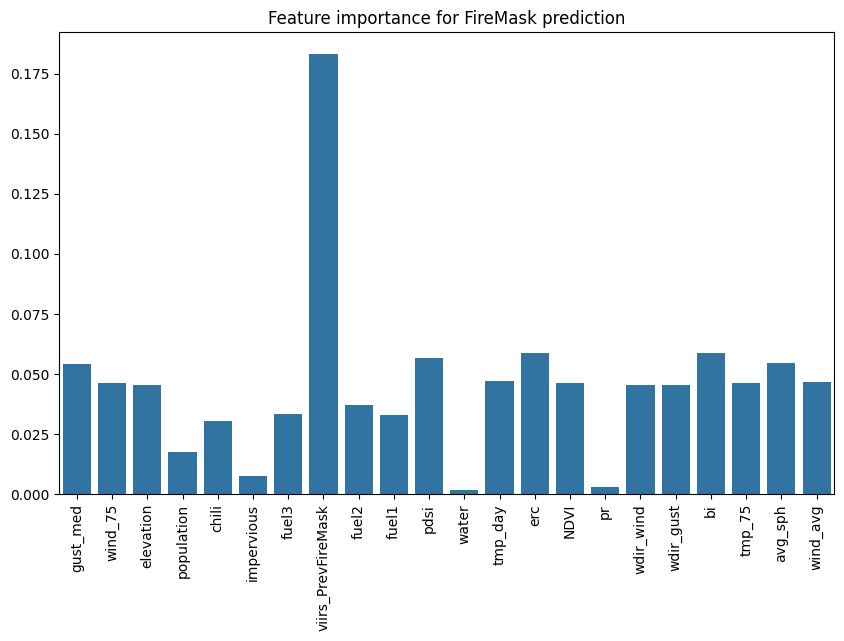

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Sample a subset for faster computation
X_sample = X_flat[::50]  # take every 50th pixel
y_sample = y_flat[::50]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_sample, y_sample)
importances = rf.feature_importances_

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x=feature_names, y=importances)
plt.xticks(rotation=90)
plt.title("Feature importance for FireMask prediction")
plt.show()


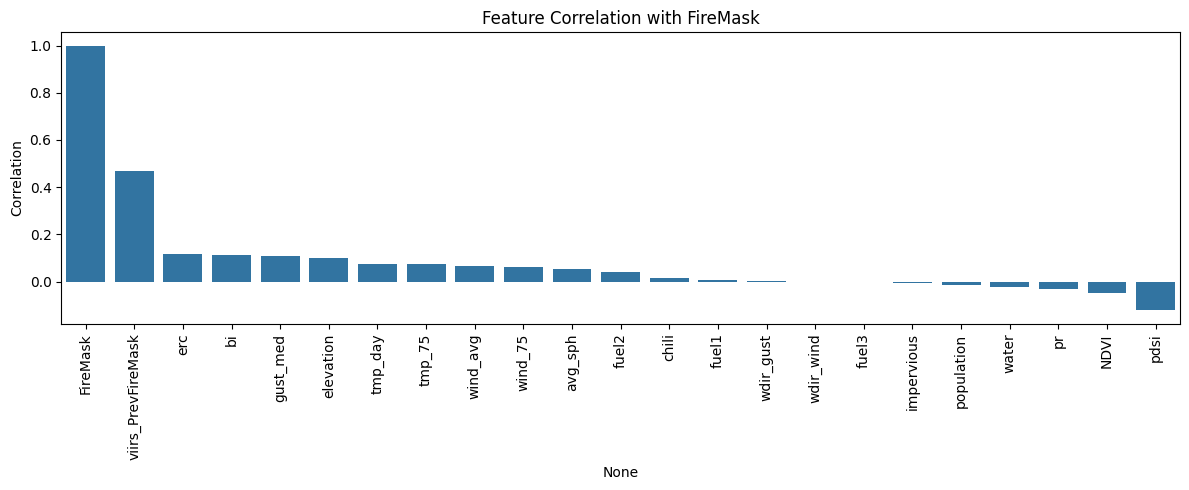

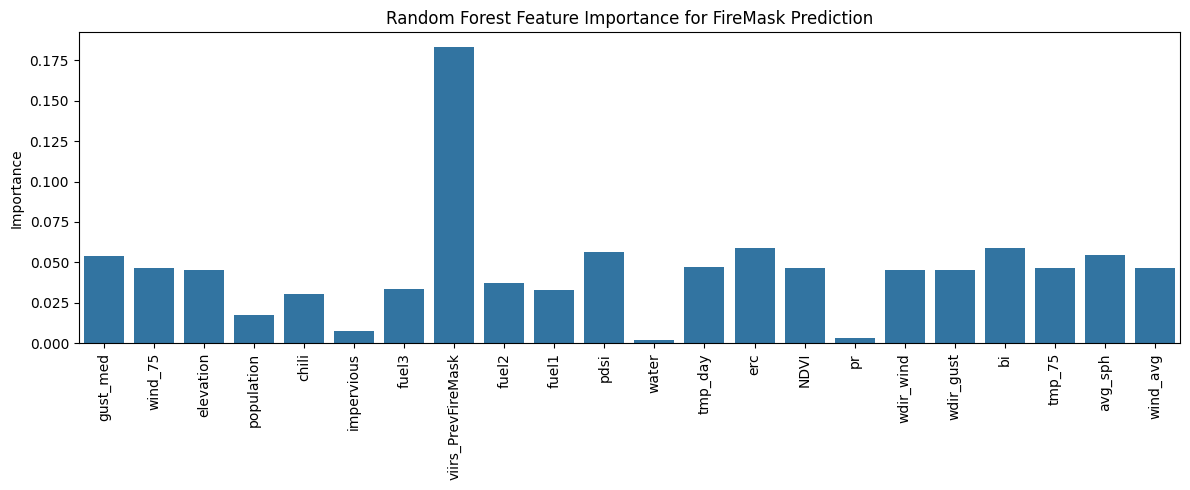

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1️⃣ Feature Correlation Plot
# -----------------------------
plt.figure(figsize=(12,5))
sns.barplot(x=corr.index, y=corr.values)
plt.xticks(rotation=90)
plt.title("Feature Correlation with FireMask")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

# -----------------------------
# 2️⃣ Feature Importance Plot
# -----------------------------
plt.figure(figsize=(12,5))
sns.barplot(x=feature_names, y=importances)
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importance for FireMask Prediction")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()




Features present in this record:

- gust_med (length: 4096)
- wind_75 (length: 4096)
- elevation (length: 4096)
- population (length: 4096)
- chili (length: 4096)
- impervious (length: 4096)
- fuel3 (length: 4096)
- viirs_PrevFireMask (length: 4096)
- fuel2 (length: 4096)
- viirs_FireMask (length: 4096)
- fuel1 (length: 4096)
- pdsi (length: 4096)
- water (length: 4096)
- tmp_day (length: 4096)
- erc (length: 4096)
- NDVI (length: 4096)
- pr (length: 4096)
- wdir_wind (length: 4096)
- wdir_gust (length: 4096)
- bi (length: 4096)
- tmp_75 (length: 4096)
- avg_sph (length: 4096)
- wind_avg (length: 4096)


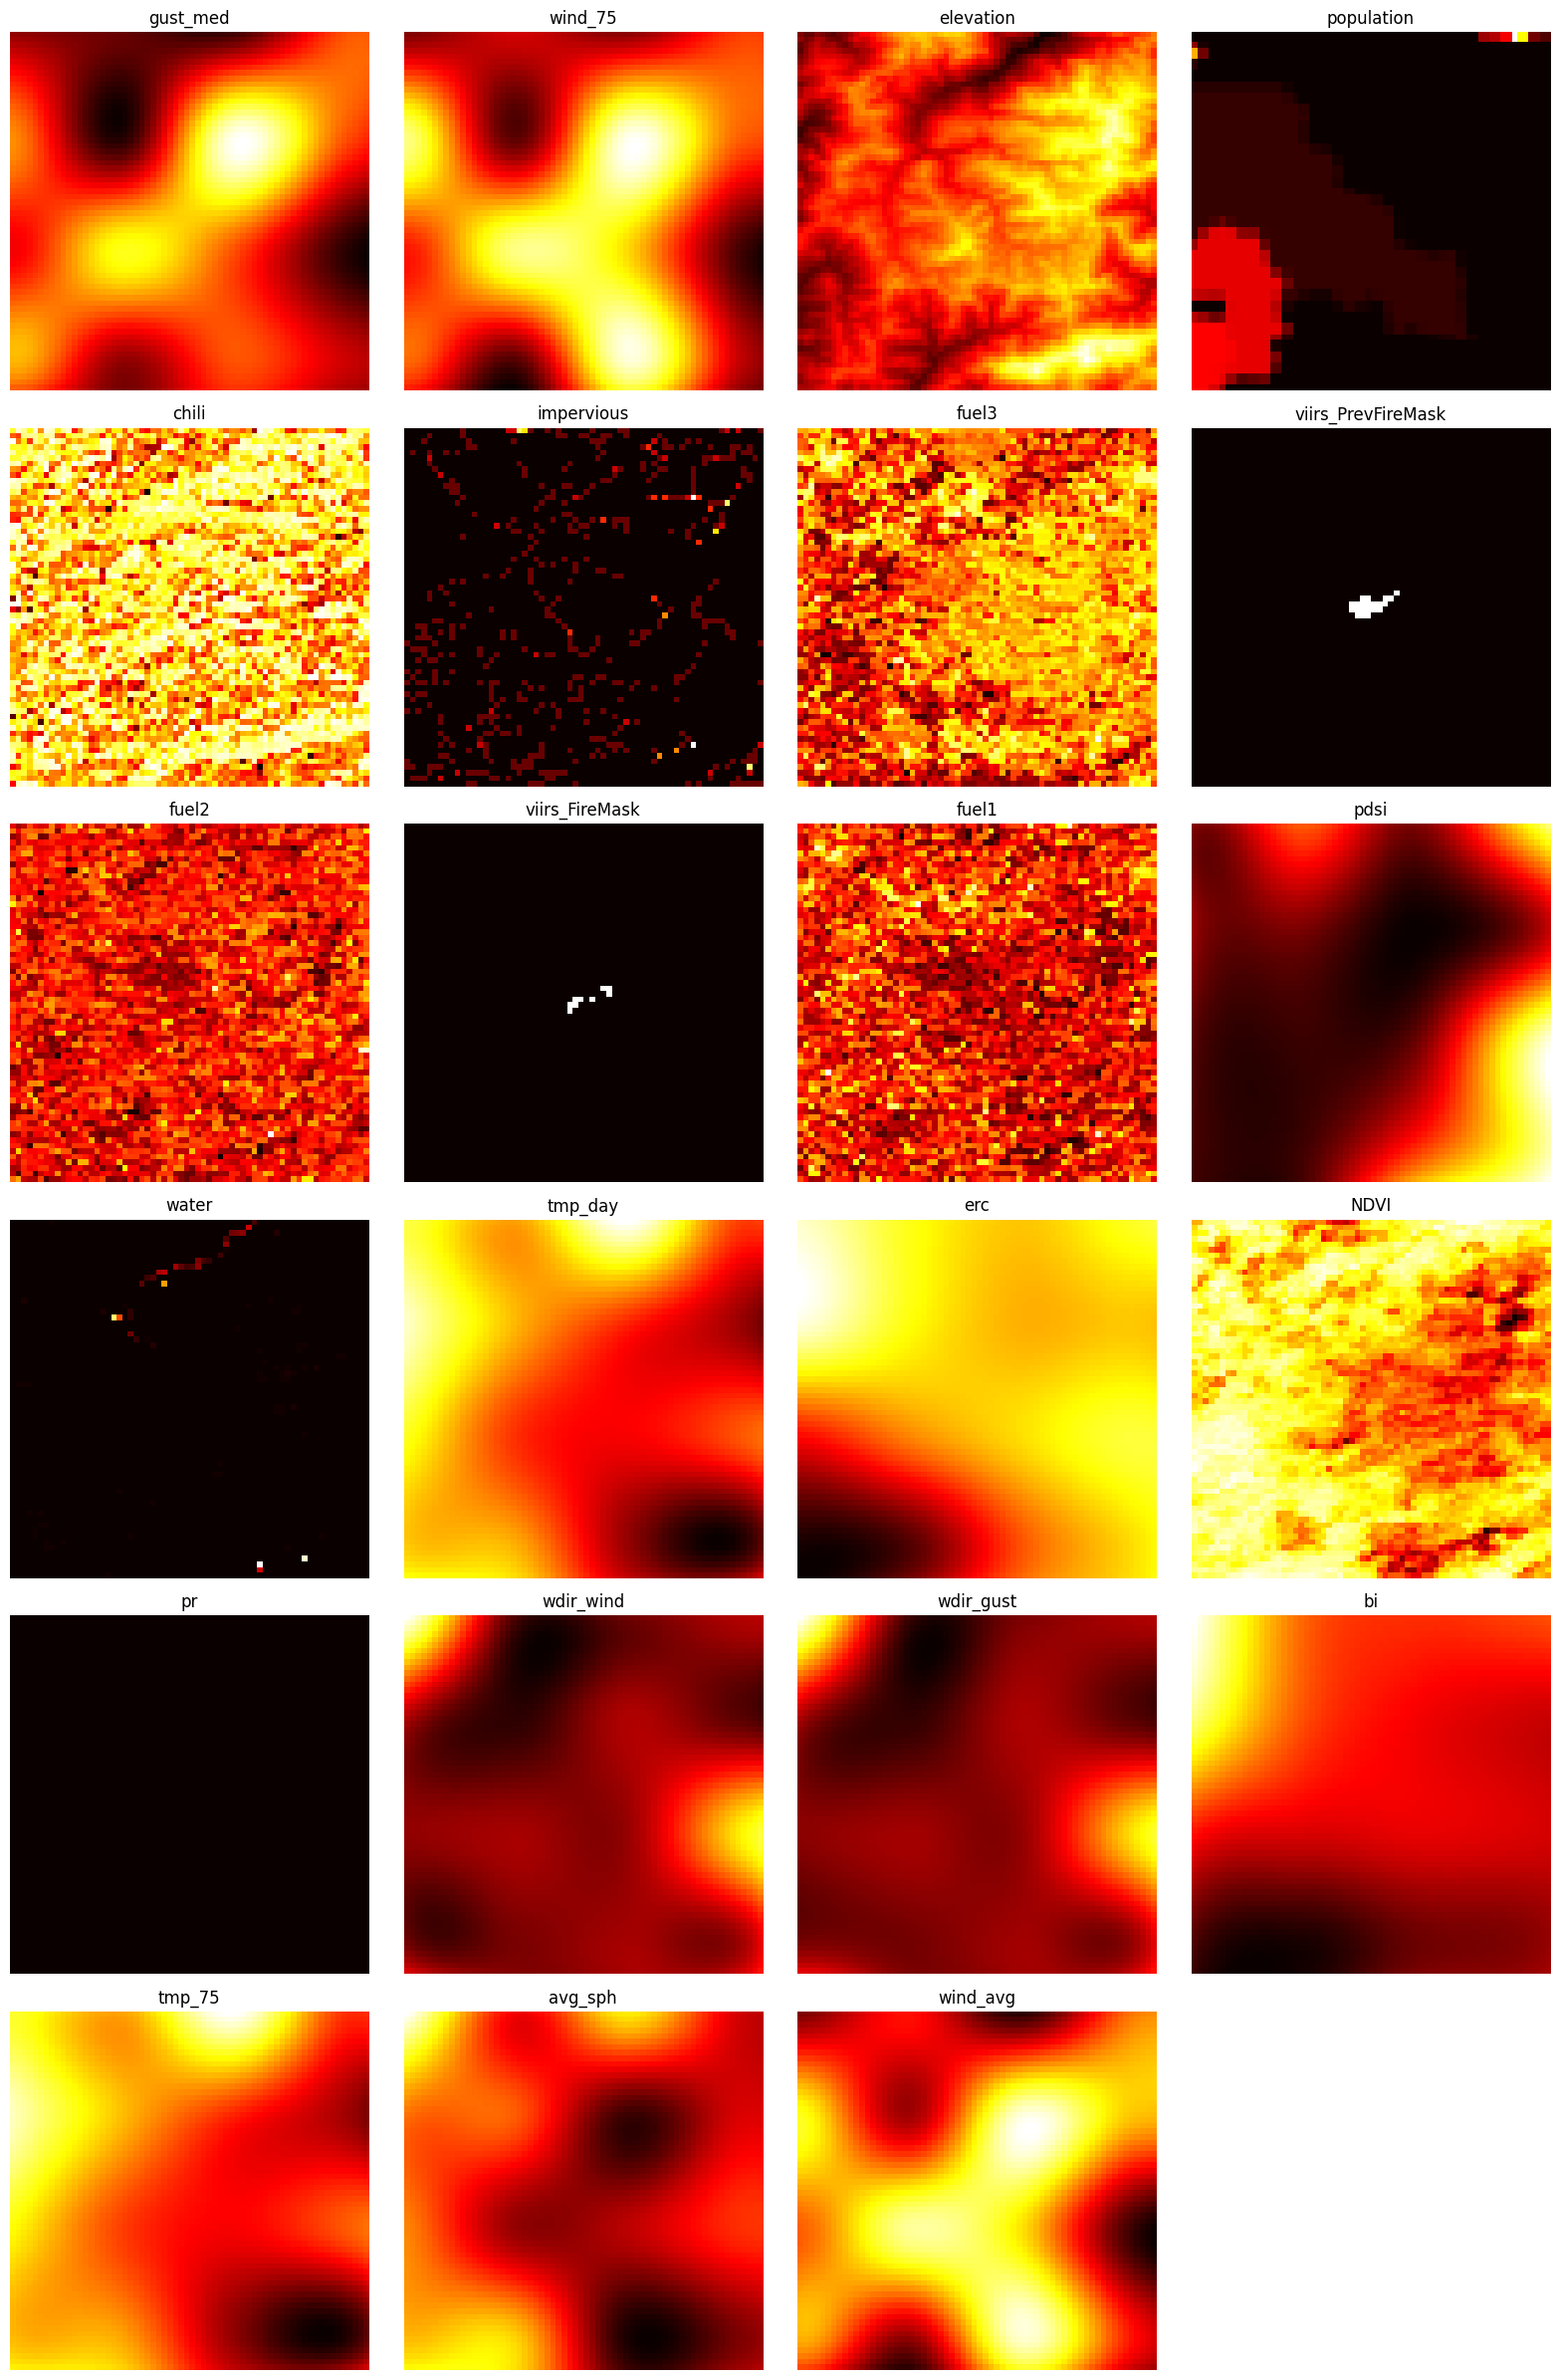

In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Pick a single TFRecord file (for example, the first eval file)
tfrecord_file = "/content/drive/MyDrive/ndws_western_dataset/cleaned_eval_ndws_conus_western_000.tfrecord"

# Create a TF dataset
raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

# Parse a single record
raw_record = next(iter(raw_dataset))
example = tf.train.Example()
example.ParseFromString(raw_record.numpy())

# Extract features
feature_dict = {k: np.array(v.float_list.value) for k, v in example.features.feature.items()}

# All feature names
feature_names = list(feature_dict.keys())
print("Features present in this record:\n")
for f in feature_names:
    print(f"- {f} (length: {len(feature_dict[f])})")

# -----------------------------
# Visualize each feature as heatmap
# -----------------------------
IMG_SIZE = int(np.sqrt(len(feature_dict[feature_names[0]])))  # Assuming square 2D features
num_features = len(feature_names)

cols = 4  # Number of columns in plot grid
rows = int(np.ceil(num_features / cols))

plt.figure(figsize=(16, 4*rows))

for i, f in enumerate(feature_names):
    arr = feature_dict[f].reshape(IMG_SIZE, IMG_SIZE)
    plt.subplot(rows, cols, i+1)
    plt.imshow(arr, cmap='hot')
    plt.title(f)
    plt.axis('off')

plt.tight_layout()
plt.show()


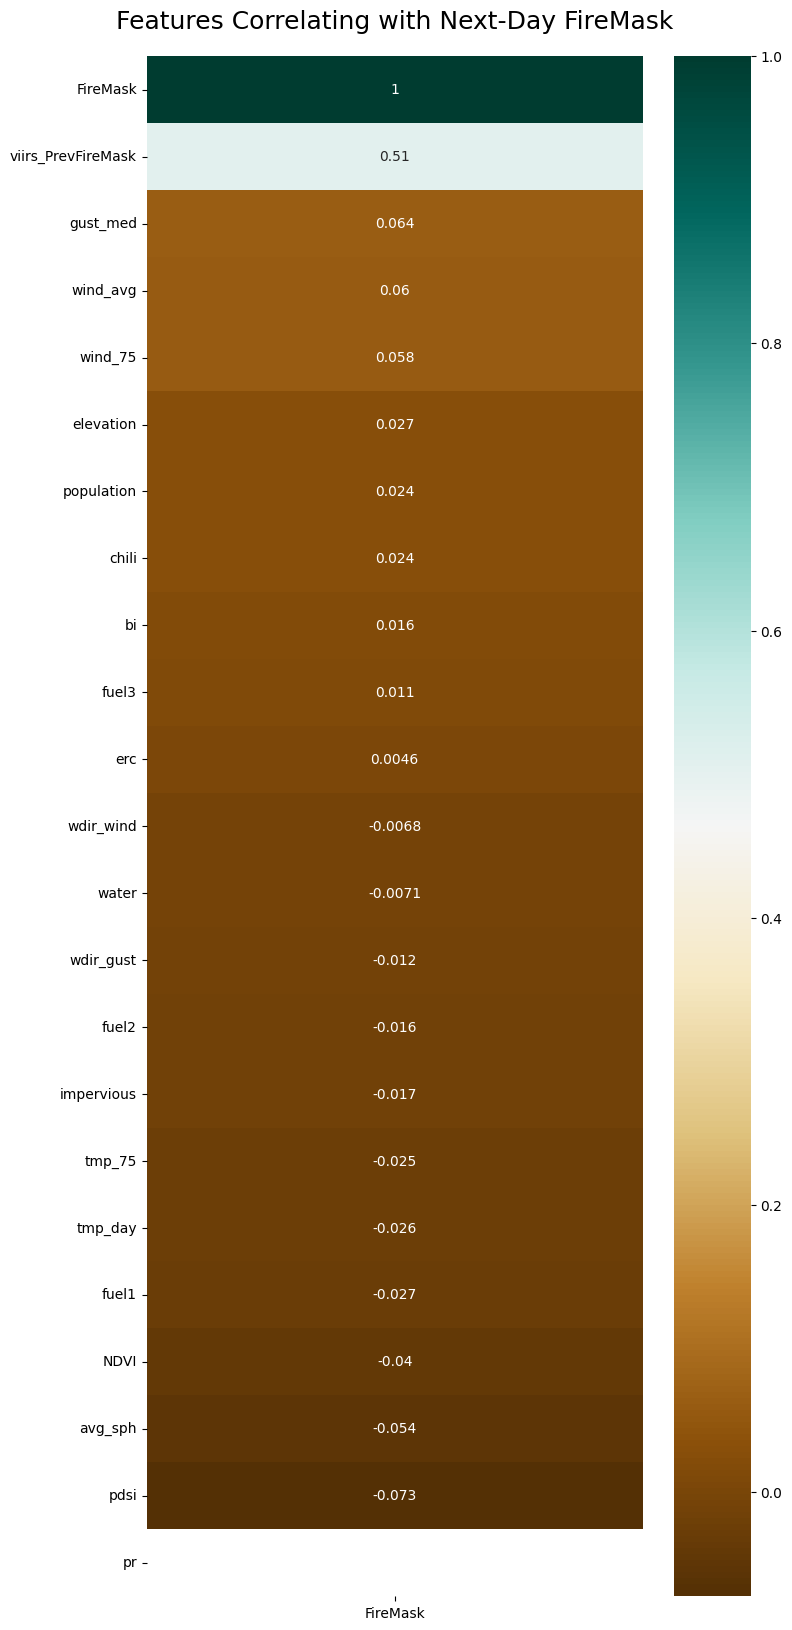

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten all features into a DataFrame
X_flat = np.stack([v for k, v in feature_dict.items() if k != 'viirs_FireMask'], axis=-1)
y_flat = feature_dict['viirs_FireMask']

feature_names = [k for k in feature_dict.keys() if k != 'viirs_FireMask']

# Create DataFrame
df = pd.DataFrame(X_flat, columns=feature_names)
df['FireMask'] = y_flat

# Compute Spearman correlation with target
corr = df.corr(method='spearman')['FireMask'].sort_values(ascending=False)

# Plot heatmap
plt.figure(figsize=(8, 20))
ax = sns.heatmap(corr.to_frame(), annot=True, cmap='BrBG', cbar=True)
ax.set_title('Features Correlating with Next-Day FireMask', fontdict={'fontsize':18}, pad=20)
plt.show()


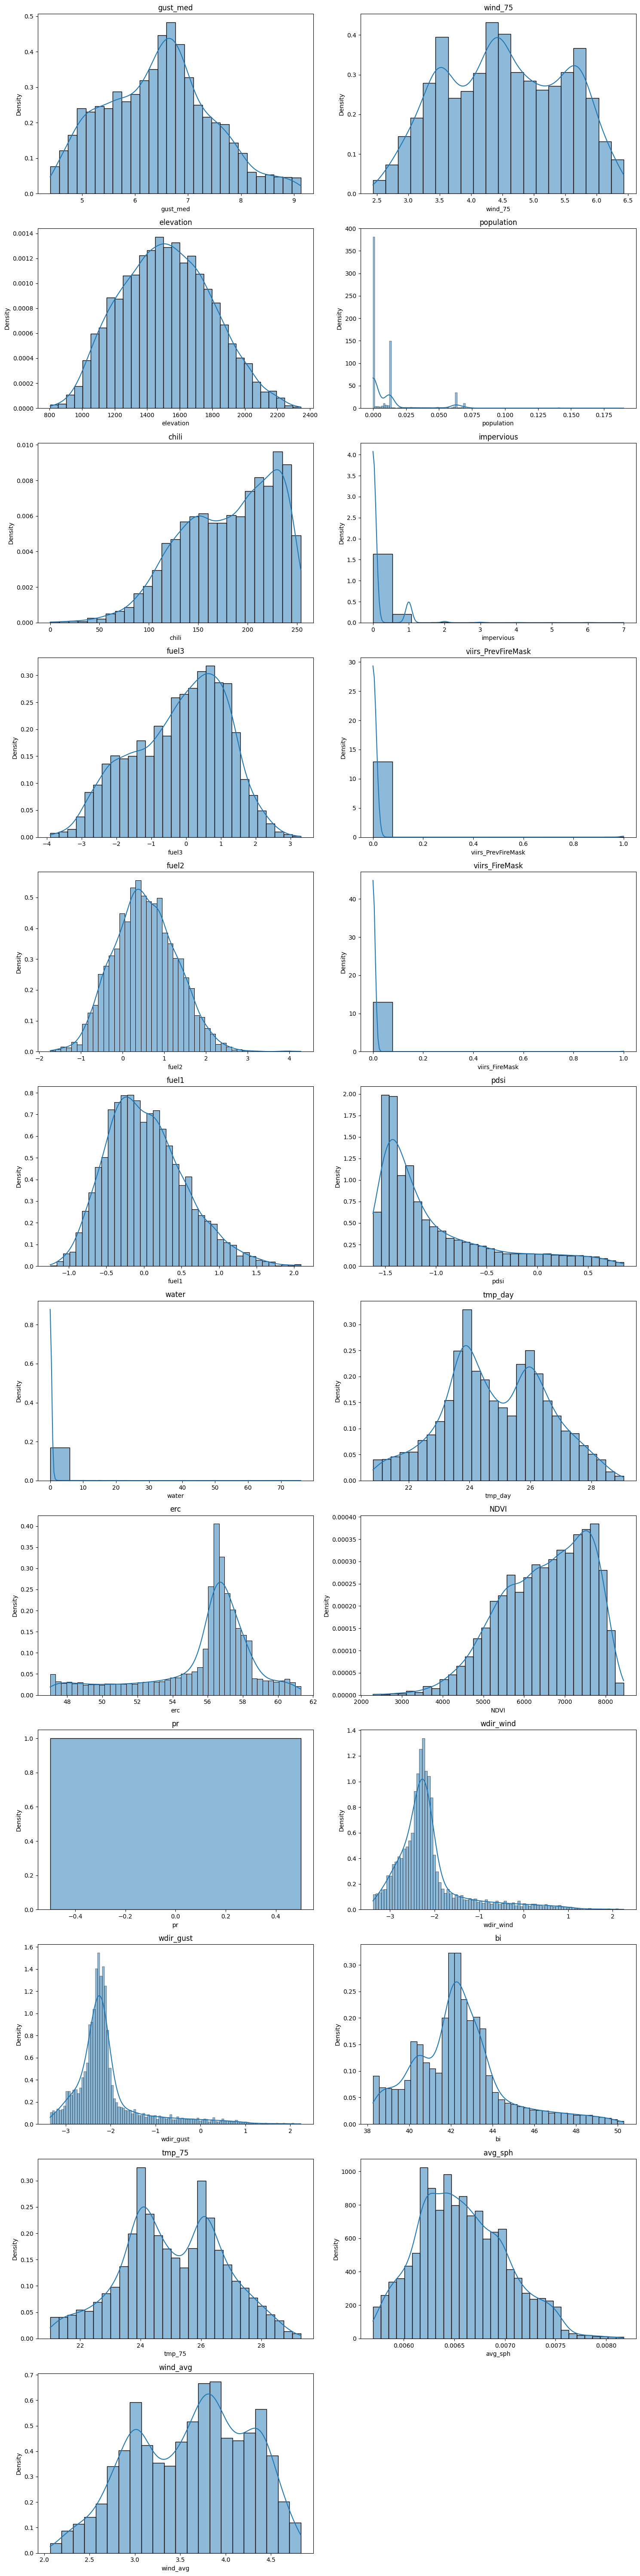

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Flatten all features into a DataFrame
X_flat = np.stack([v for k, v in feature_dict.items()], axis=-1)
feature_names = list(feature_dict.keys())

df = pd.DataFrame(X_flat, columns=feature_names)

# Determine number of columns and rows for plotting
ncols = 2
nrows = int(np.ceil(len(feature_names) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows))
axes = axes.ravel()

# Plot distribution for each feature
for i, col in enumerate(feature_names):
    sns.histplot(df[col], kde=True, stat='density', ax=axes[i])
    axes[i].set_title(col)

# Remove unused axes if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
